### **Importing Libs**

In [1]:
!pip install tensorflow-addons
!pip install git+https://github.com/tensorflow/examples.git
!pip install keras

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-lwi54f5d
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-lwi54f5d


In [2]:
from glob import glob
import os
from tensorflow_examples.models.pix2pix import pix2pix
import PIL
from PIL import Image
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import datetime, os
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output
import tensorflow_addons as tfa

import h5py

from tqdm import tqdm
import pathlib
import urllib
import cv2

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image

In [3]:
# For more information about autotune:
# https://www.tensorflow.org/guide/data_performance#prefetching
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Tensorflow ver. {tf.__version__}")

Tensorflow ver. 2.5.0


### **Importing Dataset**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!ls

drive  sample_data


### Directory to the dataset

```
RIM-ONE-r3/dataset_v2/
  healthy/stereo
  healthy/average_mask
  glaucoma_suspect/stereo
  glaucoma_suspect/avg_mask
```

In [6]:
dataset_path = "/content/drive/MyDrive/glaucoma_research/RIM-ONE-r3/dataset_v2/"
healthy_path = dataset_path + "healthy/healthy_stereo/"
healthy_masked_path = dataset_path + "healthy/avg_healthy_mask/"
glaucoma_path = dataset_path + "glaucoma_suspect/glaucoma_stereo/"
glaucoma_masked_path = dataset_path + "glaucoma_suspect/glaucoma_suspect_avg_mask/"

In [7]:
image_healthy_left = healthy_path + "N-%s-L.jpg"
image_healthy_right = healthy_path + "N-%s-R.jpg"

image_glaucoma_left = glaucoma_path + "G-%s-L.jpg"
image_glaucoma_right = glaucoma_path + "G-%s-R.jpg"

image_suspect_left = glaucoma_path + "S-%s-L" + ".jpg"
image_suspect_right = glaucoma_path + "S-%s-R" + ".jpg"

masked_healthy_disc = healthy_masked_path + "N-%d-%s-Disc-Avg.png"
masked_healthy_cup = healthy_masked_path + "N-%d-%s-Cup-Avg.png"

masked_glaucoma_disc = glaucoma_masked_path + "G-%d-%s-Disc-Avg.png"
masked_glaucoma_cup = glaucoma_masked_path + "G-%d-%s-Cup-Avg.png"

masked_suspect_disc = glaucoma_masked_path + "S-%d-%s-Disc-Avg.png"
masked_suspect_cup = glaucoma_masked_path + "S-%d-%s-Cup-Avg.png"

In [8]:
print(len(image_glaucoma_left))

106


In [9]:
### Knowing the len of the images
stereo_healthy = len(list(glob(healthy_path + "*.jpg")))
print(f"The originally healthy stereo {stereo_healthy} images.")

masked_healthy = len(glob(healthy_masked_path + "*png"))
print(f"The masked healthy {masked_healthy} images.")

stereo_glaucoma = len(glob(glaucoma_path + "*.jpg"))
print(f"The originally glaucoma stereo {stereo_glaucoma} images.")

masked_glaucoma = len(glob(glaucoma_masked_path + "*png"))
print(f"The masked glaucoma {masked_glaucoma} images.")

The originally healthy stereo 85 images.
The masked healthy 170 images.
The originally glaucoma stereo 74 images.
The masked glaucoma 148 images.


format initiation for to separate the image between left right both Healthy and Glaucoma Suspected also the disc and cups

In [10]:
def open_image(path, width, height):
    try :
        image = cv2.imread(path)
        image = cv2.resize(image, (width, height))
        return image
    except:
        return []

In [11]:
width = 256
height = 256

All the list gonna be used for the training model in one for all images category (Stereo, Disc, and Cup)

In [12]:
images_list = [] ## All Images Category in one list (Healthy, Glaucoma, Suspected)
masked_disc_list = [] ## All Disc Images Category
masked_cup_list = [] ## All Cup Images Category

Getting Image Healthy Left, Right, Masked Healty Disc and Cup.

In [13]:
healthy_list = []
masked_healthy_cup_list = []
masked_healthy_disc_list = []

for i in range(1, 93):
    healthy_left = open_image(image_healthy_left % i, width, height)
    healthy_right = open_image(image_healthy_right % i, width, height)
    if (len(healthy_left) > 0):
        healthy_list.append(healthy_left)
        images_list.append(healthy_left)
        masked_healthy_disc_left = open_image(masked_healthy_disc % (i, "L"), width, height)
        masked_healthy_disc_list.append(masked_healthy_disc_left)
        masked_disc_list.append(masked_healthy_disc_left)
        masked_healthy_cup_left = open_image(masked_healthy_cup % (i, "L"), width, height)
        masked_healthy_cup_list.append(masked_healthy_cup_left)
        masked_cup_list.append(masked_healthy_cup_left)
    elif(len(healthy_right) > 0):
        healthy_list.append(healthy_right)
        images_list.append(healthy_right)
        masked_healthy_disc_right = open_image(masked_healthy_disc % (i, "R"), width, height)
        masked_healthy_disc_list.append(masked_healthy_disc_right)
        masked_disc_list.append(masked_healthy_disc_right)
        masked_healthy_cup_right = open_image(masked_healthy_cup % (i, "R"), width, height)
        masked_healthy_cup_list.append(masked_healthy_cup_right)
        masked_cup_list.append(masked_healthy_cup_right)

In [14]:
print(len(healthy_list), len(masked_healthy_cup_list), len(masked_healthy_disc_list)) 

85 85 85


In [15]:
print(len(images_list), len(masked_cup_list), len(masked_disc_list)) 

85 85 85


Getting Image Glaucoma Left, Right, Masked Glaucoma Disc and Cup.

In [14]:
glaucoma_list = []
masked_glaucoma_disc_list = []
masked_glaucoma_cup_list = []

for i in range(1, 41):
  glaucoma_left = open_image(image_glaucoma_left % i, width, height)
  glaucoma_right = open_image(image_glaucoma_right % i, width, height)
  if (len(glaucoma_left) > 0):
    glaucoma_list.append(glaucoma_left)
    masked_glaucoma_disc_left = open_image(masked_glaucoma_disc % (i, "L"), width, height)
    masked_glaucoma_disc_list.append(masked_glaucoma_disc_left)
    masked_glaucoma_cup_left = open_image(masked_glaucoma_cup % (i, "L"), width, height)
    masked_glaucoma_cup_list.append(masked_glaucoma_cup_left)
  elif (len(glaucoma_right) > 0):
    glaucoma_list.append(glaucoma_right)
    masked_glaucoma_disc_right = open_image(masked_glaucoma_disc % (i, "R"), width, height)
    masked_glaucoma_disc_list.append(masked_glaucoma_disc_right)
    masked_glaucoma_cup_right = open_image(masked_glaucoma_cup % (i, "R"), width, height)
    masked_glaucoma_cup_list.append(masked_glaucoma_cup_right)

In [15]:
print(len(glaucoma_list), len(masked_glaucoma_disc_list), len(masked_glaucoma_cup_list)) 

39 39 39


Getting Image Suspect Left, Right, Masked Suspect Disc and Cup.

In [16]:
suspect_list = []
masked_suspect_disc_list = []
masked_suspect_cup_list = []

for i in range(1, 36):
  suspect_left = open_image(image_suspect_left % i, width, height)
  suspect_right = open_image(image_suspect_right % i, width, height)
  if (len(suspect_left) > 0):
    suspect_list.append(suspect_left)
    masked_suspect_disc_left = open_image(masked_suspect_disc % (i, "L"), width, height)
    masked_suspect_disc_list.append(masked_suspect_disc_left)
    masked_suspect_cup_left = open_image(masked_suspect_cup % (i, "L"), width, height)
    masked_suspect_cup_list.append(masked_suspect_cup_left)
  elif (len(suspect_right) > 0):
    suspect_list.append(suspect_right)
    masked_suspect_disc_right = open_image(masked_suspect_disc %  (i, "R"), width, height)
    masked_suspect_disc_list.append(masked_suspect_disc_right)
    masked_suspect_cup_right = open_image(masked_suspect_cup % (i, "R"), width, height)
    masked_suspect_cup_list.append(masked_suspect_cup_right)

In [17]:
print(len(suspect_list), len(masked_suspect_disc_list), len(masked_suspect_cup_list))

35 35 35


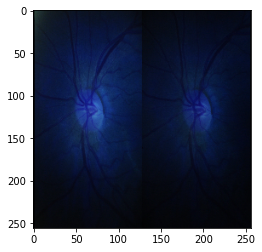

In [ ]:
plt.imshow(healthy_list[2])

### **U-Net Implementation**
implementasi u-net yang digunakan merupakan u-net versi pada umumnya

In [ ]:
# -- U-Net Implementation -- #


# -- Encoder -- #
# Block encoder 1

# --- start with uncommend the input and the output --- #
# inputs = Input(shape=input_size)
conv_enc_1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializer)(inputs)
conv_enc_1 = Conv2D(64, 3, activation = 'relu', padding='same', kernel_initializer=initializer)(conv_enc_1)

# Block encoder 2
max_pool_enc_2 = MaxPooling2D(pool_size=(2, 2))(conv_enc_1)
conv_enc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_2)
conv_enc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_2)

# Block encoder 3
max_pool_enc_3 = MaxPooling2D(pool_size=(2,2))(conv_enc_2)
conv_enc_3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=initializer)(max_pool_enc_3)
conv_enc_3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=initializer)(conv_enc_3)

# Block  encoder 4
max_pool_enc_4 = MaxPooling2D(pool_size=(2, 2))(conv_enc_3)
conv_enc_4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_4)
conv_enc_4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_4)
# -- Encoder -- #

# ==== #
maxpool = MaxPooling2D(pool_size=(2, 2))(conv_enc_4)
conv = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(maxpool)
conv = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv)
# ==== #

# -- Dencode -- #
# Block decoder 1
up_dec_1 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv))
merge_dec_1 = concatenate([conv_enc_4, up_dec_1], axis = 3)
conv_dec_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_1)
conv_dec_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_1)

# Block decoder 2
up_dec_2 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_1))
merge_dec_2 = concatenate([conv_enc_3, up_dec_2], axis = 3)
conv_dec_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_2)
conv_dec_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_2)

# Block decoder 3
up_dec_3 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_2))
merge_dec_3 = concatenate([conv_enc_2, up_dec_3], axis = 3)
conv_dec_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_3)
conv_dec_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_3)

# Block decoder 4
up_dec_4 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_3))
merge_dec_4 = concatenate([conv_enc_1, up_dec_4], axis = 3)
conv_dec_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_4)
conv_dec_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_4)
conv_dec_4 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_4)
# -- Dencoder -- #

#if start uncommend the output too
# output = Conv2D(N_CLASSES, 1, activation = 'sigmoid')(conv_dec_4)

### **Dataset Cite**

@inproceedings{
  inproceedings,
    author = {Fumero, Francisco and Sigut, Jose and Alayón, Silvia  andGonzález-Hernández, M and González de la Rosa, M},
    year = {2015},
    month = {06},
    pages = {},
    title = {Interactive Tool and Database for Optic Disc and   CupSegmentation of Stereo and Monocular Retinal Fundus Images}
}